In [2]:
# Imports
import os
import random

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

glove_path = os.path.abspath('resources/glove.bin')
w2v_path = os.path.abspath('resources/w2v.bin')

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

In [4]:
if not os.path.exists(w2v_path):
    if not os.path.exists(glove_path):
        raise OSError(f"No file found at {glove_path}. Either change this ",
                      "path in the script configuration or download a pre-",
                      "trained model from nlp.stanford.edu/projects/glove/")
    glove2word2vec(glove_path, w2v_path)

In [5]:
model = KeyedVectors.load_word2vec_format(glove_path, binary=True)

In [6]:
# Helper function for printing most similar results
def print_similar(results, dp=3):
    print('\r\n'.join(f"{w} ({s:.0{dp}f})" for w, s in results))

Unsurprisingly, human language seem intuitive to humans, but that is not the case for a computer. On the other hand, though we can easily determine whether two words share a similar meaning, if asked to give a quantitative reason as to why that is the case, we will may struggle to reach a satisfying answer. Thankfully, our shortcoming is where computers thrive, as they are remarkably good with numbers and tabular data. All this leaves us to do is to translate our problem into such a numeric system. Word embedding is a technique to take language and transform it into this computer-friendly format so we can take advantage of computing power for solving natural language processing tasks.

## Background

### The Need for Word2vec

Initial attempts at solving this problem before word embeddings included one-hot encoding. The essence of this process is to represent our text as a sequence of vectors in a space with number of dimensions equal to the number of words in our corpus. We assign each word its own dimension so that each word vector is orthogonal to the others. Technical details aside, this isn't practical to model anything on the scale of human languages, as the vector dimensions would be the size of the language (and as a results, storage and computational requirements would be astronomical). More importantly, however, this doesn't capture any sort of similarity between two words (since ever vector is mutually orthogonal to the others). As far as this method is concerned, the words 'dolphin' and 'neoliberal' are equally similar to 'shark'. Word2vec aims to solve this problem by providing word embedding which take into account relations between words. In essence, word2vec provides a canvas (albeit a strange multi-dimensional one) where any possible word in the language could lie, and plots points on this canvas for each word in our corpus. How close any two points on this canvas lie (captured mathematically by the cosine distance) should therefore correspond to how likely humans are to describe the respresented words as "similar".

In [7]:
vis_glove_path= os.path.abspath('resources/glovevis.txt')
glove_model = KeyedVectors.load_word2vec_format(vis_glove_path, binary=False)

In [8]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for idx, word in enumerate(model.vocab):
        vectors.append(model[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    pca = PCA(n_components=num_dimensions, random_state=0)
    vectors = pca.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


In [11]:
def plot_with_matplotlib(x_vals, y_vals, labels):
    # import matplotlib.pyplot as plt
    # import random

    random.seed(3)
    
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals, alpha=0.2)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("A visualisation of the two principle dimensions of this "
              "'canvas' for an\nexample corpus with a few randomly "
              "choosen words marked")

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        if labels[i] == 'blockhouse':
            # Special case to avoid overlap
            continue
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.show()

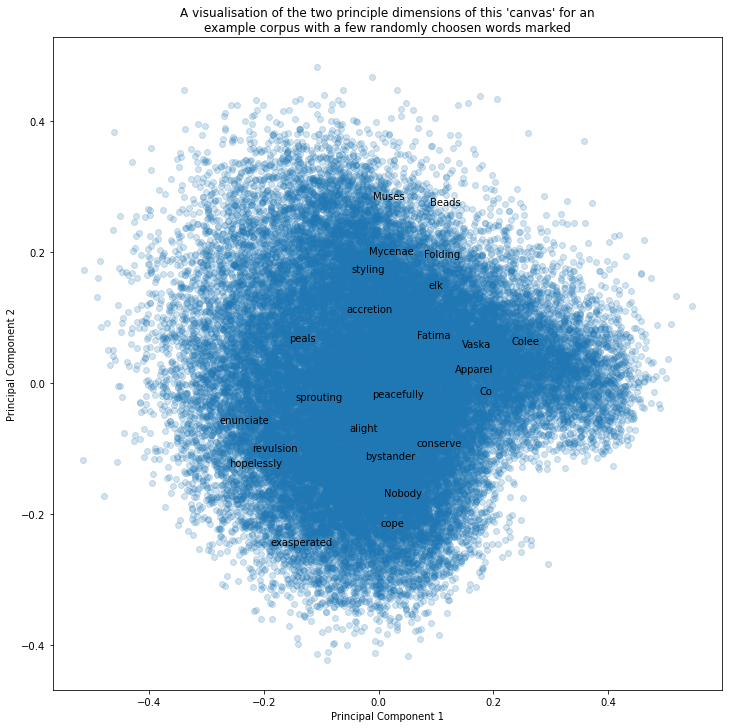

In [12]:
x_vals, y_vals, labels = reduce_dimensions(glove_model)
plot_function = plot_with_matplotlib
plot_function(x_vals, y_vals, labels)

### Deriving the Word Embeddings

To derive each word embedding, the word2vec model is usually trained using a method called Skipgram with Negative Sampling (SGNS). Essentially, a large corpus (typically billions of words) is fed to the model, and an $n$-sized sliding window is used to capture the words that lie either side of each word in the corpus to determine each word's context. The context for each word is then used to determine the word's embedding vector, with the negative sampling process controlling the rate at which these weights are updated to reduce computation time and produce a more robust result. Because words with a similar context usually have closely-linked meanings, such words will end up having similar embedding vectors too.


Take the above diagram as an example. On iteration $j$ and $k$, 'fox' and 'bear' have similar contexts, so will end up with relatively close embedding vectors. After many adjustments each time they are found in the corpus, their vectors will provide an increasingly accurate represention of the "fox" and "bear" relation—types of animals. 

## Application

Once we have trained a word embedding using word2vec, we can apply it in many different ways to extract the relationships between words in the corpus.

For example, we can find the similarity between words based on their cosine distance in the vector space. 

In [27]:
model.similarity('queen', 'throne')

0.45448625

In [25]:
model.similarity('queen', 'forklift')

-0.030027825

In [20]:
model.similarity('Queen', 'Bowie')

0.20833209

As expected, the word 'forklift' is relatively distinct from 'queen', especially when compared to 'throne'. What's fascinating, however, is that multiple facets of the word 'queen' are captured; we see that 'Bowie' is also relatively close to 'Queen' due to the word's relation to the iconic rock band.

Naturally, with vectors come mathematical operations, and the real power of word2vec starts to emerge. Vector differences are the crux behind *analogies*, a concept best explained through examples...


### Analogies

#### Starting With a Classic

The most infamous example of the use of word2vec is answering the question, "Man is to woman, as king is to...what?". As we can see, word2vec takes this puzzle in it's stride.

In [22]:
# king + (woman - man) = ...
print_similar(model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1))

queen (0.712)


This example is rather intuitive; the female version of the male title 'king' is 'queen' and so this is the natural choice to complete the analogy. To get word2vec to return this result, we have to phrase the question in the language of arthimetic; that is, `king + (woman - man)`. In other words, we are taking the word 'king' and asking what the corresponding word would be if added the difference between 'woman' and 'man'. This may seem unituitive—why can't we just add 'woman' to 'king'? The reason for this is that the word 'king' already has 'man' as a component of its vector representation. Therefore, if we simply added 'woman' without first subtracting 'man' we end up with components of both 'woman' and 'man' which confuses the model, leaving us with nonsensical results.

In [32]:
# Invalid approach: king + woman = ...
print_similar(model.most_similar(positive=['king', 'woman'], topn=1))

man (0.663)


### Plurals

We can use this system of analogy solving for finding the singular and plural forms of words. With a rather mundane example such as `gloves + (bike - bikes)`, it's not unsurprising the model returns 'glove'; it could simply be obtained from deciphering that the pattern is removing the trailing 's'—hardly groundbreaking. But when talking about irregular plurals, the required task to output the derived word shifts from spotting a simple pattern to seemingly needing a human-like understanding of the structure and complexities of the English language. Never-the-less, word2vec is up for the challenge.

In [33]:
# foot + (cacti - cactus) = ...
print_similar(model.most_similar(positive=['foot', 'cacti'], negative=['cactus'], topn=1))

feet (0.568)


In [35]:
# child + (sheep - sheep) = ...
print_similar(model.most_similar(positive=['child', 'sheep'], negative=['sheep'], topn=1))

children (0.726)


Here, 'sheep' is both the singular and the plural, meaning the result of the word arithmetic is still 'child'. But since 'child' is such a similar word to 'children', word2vec still manages to come out with the correct answer.

### Geographical analogies

We can use analogies to find cities.

In [36]:
# Portugal + (Moscow - Russia) = ...
print_similar(model.most_similar(positive=['Portugal', 'Moscow'], negative=['Russia'], topn=1))

Lisbon (0.655)


Or we can flip things around to find what country a city resides in.

In [39]:
# Delhi + (Spain - Barcelona) = ...
print_similar(model.most_similar(positive=['Delhi', 'Spain'], negative=['Barcelona'], topn=1))

India (0.626)


Finally, we can go one step up and find the geographic regions of countries.

In [38]:
# Cambodia + (Africa - Egypt) = ...
print_similar(model.most_similar(positive=['Cambodia', 'Africa'], negative=['Egypt'], topn=1))

Southeast_Asia (0.566)


The geographic intelligence of word2vec isn't limited to the form of analogy. Here we see an example in which we perform straight addition.

In [40]:
# Iran + war = ...
print_similar(model.most_similar(positive=['Iran', 'war'],topn=3))

Iraq (0.683)
Islamic_republic (0.671)
Syria (0.653)


This example shows how much geographic and political complexity is captured in the model. 'Iraq' and 'Islamic_republic' are most likely referencing the Iran-Iraq war. On the other hand Iraq and Syria, are both war-stricken countries near Iran, which could easily explain this relation.

### Opposites


When a word has a clear opposite, we can use analogy to find it.

In [42]:
# high + (big - small)
print_similar(model.most_similar(positive=['high', 'big'], negative=['small'], topn=1))

low (0.448)


Note however that we can't just negate a word to find its opposite or we obtain gibberish in return.

In [43]:
# -high
print_similar(model.most_similar(negative=['high'], topn=1))

----------_-----------------------------------------------_GS## (0.321)


The reason for this is that an opposite word in a vector space has to be opposite in every way. Even though we would say that 'high' and 'low' are opposites, they do in fact have components in common, such as how they both represent heights. For that reason the model stubbornly ignores words that are opposites in the way we intend, and instead, tries to find the word that is most dissimilar to 'high', resulting in some strange garble of characters.

### Vector Sums and Differences

As hinted at before, word2vec can solve problems far more general than analogies. Here we look at some examples of generic vector sums and differences.

In [45]:
# death + water = ...
print_similar(model.most_similar(positive=['death', 'water'], topn=3))

drowning (0.556)
drowing (0.545)
scalding_bath (0.526)


In [44]:
# death + knife = ...
print_similar(model.most_similar(positive=['death', 'knife'], topn=3))

kitchen_knife (0.644)
stabbing (0.637)
murder (0.634)


In [48]:
# girlfriend - love = ...
print_similar(model.most_similar(positive=['girlfriend'], negative=['love'], topn=3))

ex_girlfriend (0.517)
fiancee (0.479)
estranged_wife (0.476)


The second result is rather strange. If you have a theory of where this relation might have come from, make sure to comment below.

In [49]:
# colleague + love = ...
print_similar(model.most_similar(positive=['colleage', 'love'], topn=3))

loved (0.580)
friend (0.551)
pal (0.542)


With the last example we can see a shortcoming of the word2vec model. It appears that 'love' has a much stronger vector representation than 'collegue'; that is, the term captures more complexity, which makes sense. For this reason, the term 'love' can overpower the sum so that a word similar to 'love', 'loved' can be returned as highly similar even though it doesn't relate much to the word 'collegue'. Despite this, the other two preditions are strong.

### Miscellaneous 

To wrap up our examples, we will look at some miscellaneous analogies involving people and places.

In [20]:
# Obama + (Russia - USA) = ...
print_similar(model.most_similar(positive=['Obama', 'Russia'], negative=['USA'], topn=3))

Medvedev (0.674)
Putin (0.647)
Kremlin (0.617)


In [50]:
# UK + (Hitler - Germany) = ...
print_similar(model.most_similar(positive=['UK', 'Hitler'], negative=['Germany'], topn=3))

Tony_Blair (0.522)
Oliver_Cromwell (0.509)
Maggie_Thatcher (0.506)


Make of the above what you will...

In [53]:
# Apple + (Gates - Microsoft) = ...
print_similar(model.most_similar(positive=['Apple', 'Gates'], negative=['Microsoft'], topn=1))               

Steve_Jobs (0.523)


In [58]:
# Victoria Beckham + (Barack Obama - Michelle) = ...
print_similar(model.most_similar(positive=['Victoria_Beckham', 'Barack_Obama'], negative=['Michelle'], topn=1))

David_Beckham (0.528)


In [59]:
# Manchester + (Anfield - Liverpool) = ...
print_similar(model.most_similar(positive=['Manchester', 'Anfield'], negative=['Liverpool'], topn=1))

Old_Trafford (0.765)


## Word2Vec in the Wild

Above, we have seen some fairly isolated applications of the word2vec model, but that is not to say that there are not wider reaching use cases. For example, word2vec is often a key step in the production of sentiment analysis models (See: [a WDSS virtual talk on the use of sentiment analysis for predicting presidential approval](https://youtu.be/l40-JFn6F9M?t=1845)), recommender systems, and chat bots. Aside from these ecommerce-centric examples, word2vec has also flurished in scientific applications such as BioNLP, which have utilised word embeddings for advancements in knowledge.

Hopefully, through these examples, the potential power of Word2Vec has been made clear. Thank you reading.